In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
import os
import pandas as pd
from torchvision.io import read_image
import tarfile
from PIL import Image
import pickle
import cv2
import scipy
from tqdm import tqdm
from scipy import spatial

In [2]:
def get_file_list(file_path = "./image_data/"):
    import random
    file_list = []
    assert os.path.isdir(file_path)
    for file in os.listdir(file_path):
        file_list.append(file_path+file)
    return file_list

In [3]:
class Collection(Dataset):
    def __init__(self, image_path, transform=None):
        super().__init__()
        self.image_path = image_path
        self.transform = transform
    def __getitem__(self, index):
        image_path = self.image_path[index]
        image = Image.open(image_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, image_path
    def __len__(self):
        return len(self.image_path)

In [4]:
def load_data(data_path, batch_size = 4, shuffle=False, transform='default'):
    default_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.225, 0.225, 0.225))
    ]) if transform == 'default' else transform

    image_path_list = get_file_list(file_path=data_path)
    
    collection = Collection(image_path=image_path_list, transform = default_transform)

    dataloader = DataLoader(dataset=collection, batch_size=batch_size, shuffle=shuffle, num_workers=0)
    return dataloader

    

In [5]:
def feature_extract(model, dataloader):
    features = torch.FloatTensor()
    path_list = []
    for img, path in dataloader:
        img = img.cuda()
        input = Variable(img)
        output = model(input)
        feature = output.data.cpu()
        feature_norm = torch.norm(feature, p=2, dim=1, keepdim=True)
        feature = feature.div(feature_norm.expand_as(feature))
        features = torch.cat((features, feature), 0)
        path_list += list(path)
    return features, path_list

In [6]:
def create_query_folder(path = "./image_annotation/"):
    query_list = []
    file_name = []
    for query in os.listdir(path):
        if query.split('.')[0].split('_')[-1] == "query":
            file_name.append(query.split('.')[0] + '.jpg')
            file = open(path+query, 'r')
            content = file.readline().split()
            crop_img, x, y, w, h = content
            file.close()
            crop_img = crop_img.split('_')[1::]
            crop_img = '_'.join(crop_img)
            query_list.append((crop_img + '.jpg', x, y, w, h))
    query_dir = "./image_data/"
    query_des = "./image_query/"
    for item in range(len(query_list)):
        img = cv2.imread(query_dir+query_list[item][0])
        x, y, w, h = float(query_list[item][1]), float(query_list[item][2]), float(query_list[item][3]), float(query_list[item][4])
        img = img[int(x):int(x+w), int(y):int(y+h)]
        cv2.imwrite(query_des+file_name[item], img)

In [8]:
create_query_folder()

In [25]:
def load_model_vgg():
    model = models.vgg16(pretrained=True)
    model.classifier = model.classifier[:-1]
    model = model.eval()
    model = model.cuda()
    return model

In [8]:
def load_model_resnet():
    model = models.resnet101(pretrained=True)
    modules = list(model.children())[:-1]
    model = nn.Sequential(*modules)
    model = model.cuda()
    mdoel = model.eval()
    return model

In [53]:
def compute_score(query_feature, collection_feature):
    score = [spatial.distance.cosine(query_feature, feature) for feature in collection_feature]
    idx = np.argsort(score, axis=0)
    score = sorted(score)
    return score, idx

In [26]:
model = load_model_vgg()

In [27]:
dataloader = load_data("./image_data/", batch_size=8, shuffle=False, transform='default')

In [28]:
collection, image_paths = feature_extract(model=model, dataloader=dataloader)

In [29]:
q_dataloader = load_data("./image_query/", batch_size=1, shuffle=False, transform='default')
query_feature, q_path = feature_extract(model=model, dataloader=q_dataloader)

In [35]:
dir = ["./collection_features.pkl", "./collection_paths.txt", "./query_features.pkl", "./query_paths.txt"]
content = [collection, image_paths, query_feature, q_path]
for i in range(len(dir)):
    file = open(dir[i], "wb")
    pickle.dump(content[i], file)
    file.close()

In [40]:
collection = pickle.load(open("./image_retrieval/resnet101_extractor_result/collection_features.pkl", "rb"))
image_paths = pickle.load(open("./image_retrieval/resnet101_extractor_result/collection_paths.txt", "rb"))
query_feature = pickle.load(open("./image_retrieval/resnet101_extractor_result/query_features.pkl", "rb"))
q_path = pickle.load(open("./image_retrieval/resnet101_extractor_result/query_paths.txt", "rb"))

In [30]:
retrieval = []
for q in query_feature:
    similarity, index = compute_score(query_feature=q, collection_feature=collection)
    sorted_paths = [image_paths[i] for i in index]
    retrieval.append(sorted_paths)

In [19]:
def calculate_AP_mAP_at_k(label_dir = "./image_annotation/", index = np.arange(0, 55), sorted_path_list = retrieval, k=len(collection)):
    query = []
    for file in os.listdir(label_dir):
        if file.split('.')[0].split('_')[-1] == "query":
            query.append(file.split('.')[0])
    labels = []
    for i in index:
        temp = []
        for file in os.listdir(label_dir):
            if file.split('.')[0] == query[i].replace("query", "good"):
                temp.append(file)
            elif file.split('.')[0] == query[i].replace("query", "junk"):
                temp.append(file)
            elif file.split('.')[0] == query[i].replace("query", "ok"):
                temp.append(file)
            if len(temp) == 3:
                labels.append(temp)
                break
    labels_content = []
    for q in labels:
        tmp = []
        for file in q:
            f = open(label_dir+file, 'r')
            content = f.read().split()
            tmp.extend(content)
            f.close()
        labels_content.append(tmp)
    ap = []
    for i in range(len(index)):
        precision = []
        relevant_doc = 0
        retrieved_doc = 0
        for path in sorted_path_list[index[i]][:k-1]:
            retrieved_doc += 1
            if path.split('/')[-1].split('.')[0] in labels_content[i]:
                relevant_doc += 1
                precision.append(relevant_doc/retrieved_doc)
        ap.append(np.mean(precision) if precision else 0)
    return ap, np.mean(ap)
            

In [20]:
def ploting_precision_recall(label_dir = "./image_annotation/", index = np.arange(0, 55), sorted_path_list = retrieval, save=False):
    query = []
    for file in os.listdir(label_dir):
        if file.split('.')[0].split('_')[-1] == "query":
            query.append(file.split('.')[0])
    labels = []
    for i in index:
        temp = []
        for file in os.listdir(label_dir):
            if file.split('.')[0] == query[i].replace("query", "good"):
                temp.append(file)
            elif file.split('.')[0] == query[i].replace("query", "junk"):
                temp.append(file)
            elif file.split('.')[0] == query[i].replace("query", "ok"):
                temp.append(file)
            if len(temp) == 3:
                labels.append(temp)
                break
    labels_content = []
    for q in labels:
        tmp = []
        for file in q:
            f = open(label_dir+file, 'r')
            content = f.read().split()
            tmp.extend(content)
            f.close()
        labels_content.append(tmp)
    for i in range(len(index)):
        precision = []
        recall = []
        relevant_doc = 0
        retrieved_doc = 0
        length = len(labels_content[i])
        for path in sorted_path_list[index[i]]:
            retrieved_doc += 1
            if path.split('/')[-1].split('.')[0] in labels_content[i]:
                relevant_doc += 1
                precision.append(relevant_doc/retrieved_doc)
                recall.append(relevant_doc/length)
            if relevant_doc == length:
                break
        plt.figure()
        plt.title(f"Precision-Recall curve of {query[i]}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.plot(recall, precision)
        if save:
            plt.savefig(f"image_retrieval/vgg16_plot/Precision_recall_curve_{query[i]}.jpg")
        plt.show()    
              

In [ ]:
ploting_precision_recall()

In [31]:
ap_20, map_20 = calculate_AP_mAP_at_k(k=20)
ap_100, map_100 = calculate_AP_mAP_at_k(k=100)
ap_500, map_500 = calculate_AP_mAP_at_k(k=500)
ap_1000, map_1000 = calculate_AP_mAP_at_k(k=1000)
ap, map = calculate_AP_mAP_at_k()

In [32]:
map

0.25837397492456177

In [33]:
df = pd.DataFrame()
df['Query path'] = q_path
df['AP'] = ap
df['AP@20'] = ap_20
df['AP@100'] = ap_100
df['AP@500'] = ap_500
df['AP@1000'] = ap_1000
df.to_csv('resnet101_retrieval_results.csv', index=False)

In [34]:
df

,Query path,AP,AP@20,AP@100,AP@500,AP@1000
0,./image_query/all_souls_1_query.jpg,0.211379,0.692446,0.554080,0.341987,0.268650
1,./image_query/all_souls_2_query.jpg,0.210757,0.878892,0.612475,0.402139,0.298348
2,./image_query/all_souls_3_query.jpg,0.270138,0.910385,0.787089,0.456775,0.339384
3,./image_query/all_souls_4_query.jpg,0.141330,0.560317,0.310895,0.233426,0.195522
4,./image_query/all_souls_5_query.jpg,0.032769,0.000000,0.040251,0.030763,0.025263
5,./image_query/ashmolean_1_query.jpg,0.102422,0.449495,0.242273,0.141141,0.123643
6,./image_query/ashmolean_2_query.jpg,0.017555,0.000000,0.041898,0.027893,0.022822
7,./image_query/ashmolean_3_query.jpg,0.022278,0.000000,0.000000,0.025400,0.024794
8,./image_query/ashmolean_4_query.jpg,0.441466,0.888851,0.644442,0.521004,0.486665
9,./image_query/ashmolean_5_query.jpg,0.137739,0.608333,0.304554,0.183819,0.161158


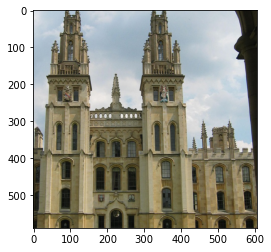

In [46]:
plt.imshow(Image.open(q_path[2]))

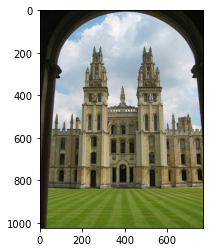

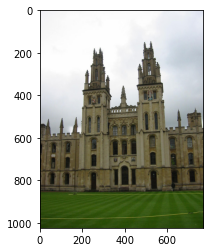

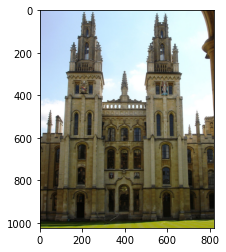

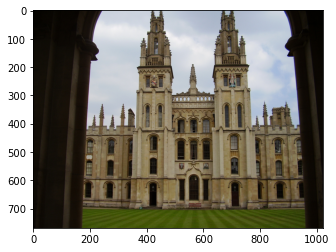

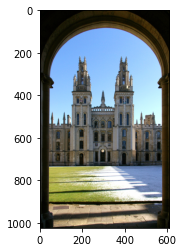

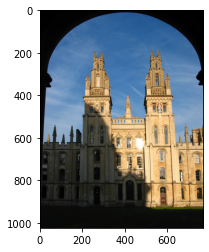

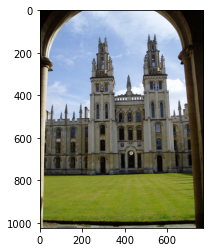

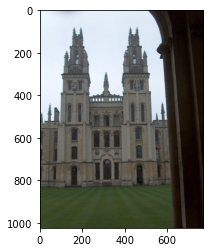

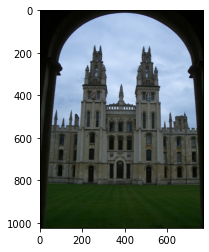

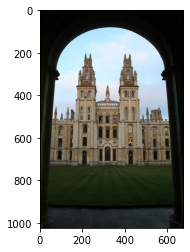

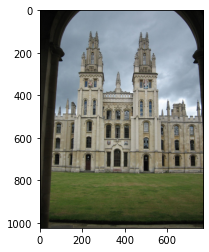

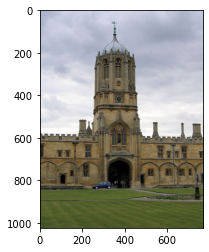

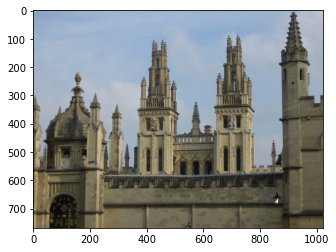

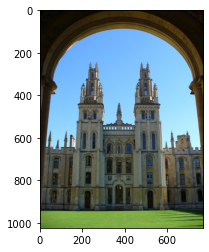

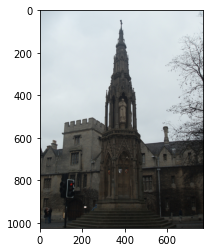

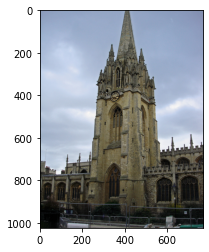

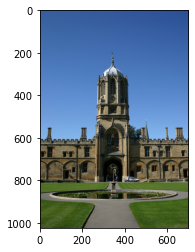

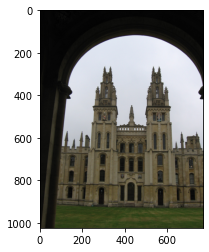

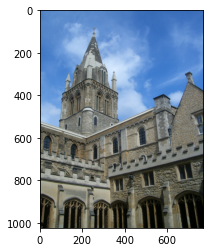

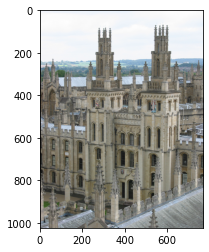

In [93]:
for img in retrieval[2][:20]:
    plt.figure()
    plt.imshow(Image.open(img))